#### Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(3)

In [2]:
FILE_PATH = "train.csv"

In [3]:
data = pd.read_csv(FILE_PATH)

In [4]:
data.columns

Index(['date_time', 'deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'],
      dtype='object')

In [5]:
data.dtypes

date_time                  object
deg_C                     float64
relative_humidity         float64
absolute_humidity         float64
sensor_1                  float64
sensor_2                  float64
sensor_3                  float64
sensor_4                  float64
sensor_5                  float64
target_carbon_monoxide    float64
target_benzene            float64
target_nitrogen_oxides    float64
dtype: object

<AxesSubplot:>

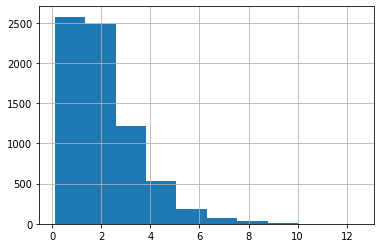

In [6]:
data.target_carbon_monoxide.hist()

<AxesSubplot:>

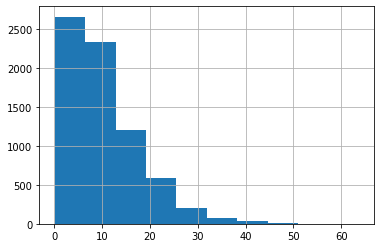

In [7]:
data.target_benzene.hist()

<AxesSubplot:>

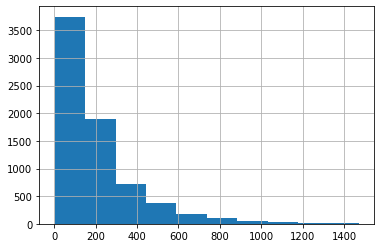

In [8]:
data.target_nitrogen_oxides.hist()

## Roadmap
- [ ] look at each numerical column and normalize it
- [ ] train a simple MLP with poisson loss in flax
- [ ] submit

In [9]:
X = data.iloc[:, 1:-3].values
Y = data.iloc[:, -3:].values

In [10]:
n = X.shape[0]
X.shape, Y.shape, n

((7111, 8), (7111, 3), 7111)

In [11]:
shuffle_seed = np.random.seed(15)
index_train, index_val = np.split(np.random.permutation(n), [int(n * 0.8)])

In [12]:
X_train, Y_train = X[index_train], Y[index_train]

In [13]:
means, stds = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True)
assert stds.min() > 0.0

In [14]:
X_train = (X_train - means) / stds

# Jax

In [15]:
import jax
import jax.numpy as jnp
import jax.random as random

In [16]:
import flax.linen as nn
from typing import Sequence

In [17]:
import optax

In [18]:
from jax.tree_util import tree_map

In [19]:
from jax.tree_util import tree_map

In [20]:
class MLP(nn.Module):
    layer_sizes: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        
        for layer_ix, layer_size in enumerate(self.layer_sizes):
            x = nn.Dense(layer_size)(x)
            if layer_ix != len(self.layer_sizes) - 1:
                x = nn.gelu(x)
        
        return x
    

In [30]:
p, m = X_train.shape[1], Y_train.shape[1]
num_h_layers = 0
h = 16  # hidden layer size
lr = 1e-3  # learning rate
num_epochs = 1
batch_size = 32

In [31]:
def poisson_loss(y, predicted):
    """
    Poisson regression loss, parameterized so that `predicted` can take any scalar value (can be negative).
    """
    return - y * predicted + jnp.exp(predicted)

def rmse(y, predicted):
    return jnp.sqrt((y - jnp.exp(predicted)) ** 2)

jax_poisson = jax.vmap(jax.jit(poisson_loss), in_axes=0)
jax_rmse = jax.vmap(jax.jit(rmse), in_axes=0)

In [35]:
def train_step(params, opt_state, x, y, model, optimizer):
    def loss_fn(params):
        predicted = model.apply(params, x)
        return jnp.mean(jnp.mean(jax_rmse(y, predicted), 0))
    loss_step, grad_step = jax.value_and_grad(loss_fn)(params)
    params_updates, opt_state = optimizer.update(grad_step, opt_state)
    params = optax.apply_updates(params, params_updates)
    rmse_step = jnp.mean(jnp.mean(jax_rmse(y, model.apply(params, x)), 0))
    return params, opt_state, loss_step, rmse_step

In [36]:
import tensorflow as tf
import tensorflow_datasets as tfds
def get_dataset(x_data, y_data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    data = data.shuffle(buffer_size=1000)
    data = data.batch(batch_size)
    return tfds.as_numpy(data)

In [43]:

# mlp = MLP([h for _ in range(num_h_layers)] + [m])
mlp = MLP([h for _ in range(num_h_layers)] + [p])
key = random.PRNGKey(1515)

key, init_key = random.split(key)
dummy_input = random.normal(key, shape=(32, p))
key, init_key = random.split(key)
params = mlp.init(init_key, dummy_input)

optimizer = optax.adam(lr)
opt_state = optimizer.init(params)


In [44]:
losses = []
for epoch_ix in range(num_epochs):
    step = 0
    for (x_train, y_train) in get_dataset(X_train, Y_train, batch_size=batch_size):
        fake_y = x_train * 2.0
        params, opt_state, loss_step, rmse_step = train_step(params, opt_state, x_train, fake_y, mlp, optimizer)
        losses.append(loss_step)
        step += 1
        if step % 5 == 0:
            print(f"Step {step}, RMSE: {rmse_step:.3f}, Poisson Loss: {loss_step:.3f}")

Step 5, RMSE: 2.066, Poisson Loss: 2.071
Step 10, RMSE: 1.938, Poisson Loss: 1.943
Step 15, RMSE: 2.029, Poisson Loss: 2.034
Step 20, RMSE: 2.037, Poisson Loss: 2.042
Step 25, RMSE: 1.915, Poisson Loss: 1.920
Step 30, RMSE: 2.641, Poisson Loss: 2.648
Step 35, RMSE: 2.116, Poisson Loss: 2.120
Step 40, RMSE: 2.018, Poisson Loss: 2.022
Step 45, RMSE: 2.129, Poisson Loss: 2.134
Step 50, RMSE: 1.929, Poisson Loss: 1.933
Step 55, RMSE: 1.771, Poisson Loss: 1.774
Step 60, RMSE: 1.752, Poisson Loss: 1.755
Step 65, RMSE: 1.852, Poisson Loss: 1.855
Step 70, RMSE: 1.906, Poisson Loss: 1.909
Step 75, RMSE: 1.736, Poisson Loss: 1.739
Step 80, RMSE: 2.082, Poisson Loss: 2.086
Step 85, RMSE: 2.068, Poisson Loss: 2.071
Step 90, RMSE: 1.817, Poisson Loss: 1.820
Step 95, RMSE: 1.949, Poisson Loss: 1.953
Step 100, RMSE: 1.804, Poisson Loss: 1.807
Step 105, RMSE: 1.674, Poisson Loss: 1.677
Step 110, RMSE: 1.804, Poisson Loss: 1.806
Step 115, RMSE: 1.807, Poisson Loss: 1.810
Step 120, RMSE: 1.540, Poisson 

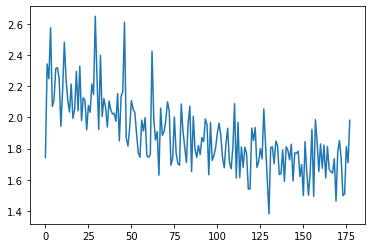

In [45]:
plt.plot(losses)